# Logistic Regression: A Classification Problem

$ \textbf{y} = sigmoid(\textbf{A}\times \textbf{x} + \textbf{b})$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os.path
import csv

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
tf.reset_default_graph()

# Create graph
sess = tf.Session()

## Obtain and prepare data for modeling

We will use the 'Low Birthrate Dataset' is a dataset from a famous study by Hosmer and Lemeshow in 1989 called, "Low Infant Birth Weight Risk Factor Study". It is a very commonly used academic dataset mostly for logistic regression. 

In a study investigating the risk factors for low birth weight babies, the risk factors
considered were:
>* Race
* Smoking status of mother
* History of high blood pressure
* History of premature labor
* Presence of uterine irritability
* Mother’s pre-pregnancy weight

The 56 women who gave birth to low weight babies in this study were matched on the basis of age with a randomly selected control mother (i.e. each control gave birth to a normal weight baby and was the same age as the “case” mother).

In our model:
```
#  y = 0 or 1 = low birth weight
#  x = demographic and medical history data
```

In [8]:
!ls ./data

birth_weight.csv       mnist-test-labels.gz    mnist-train-labels.gz
mnist		       mnist-test-labels.npy   mnist-train-labels.npy
mnist-test-images.gz   mnist-train-images.gz
mnist-test-images.npy  mnist-train-images.npy


In [9]:
# name of data file
birth_weight_file = './data/birth_weight.csv'

# read birth weight data into memory
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
     csv_reader = csv.reader(csvfile)
     birth_header = next(csv_reader)
     for row in csv_reader:
         birth_data.append(row)

birth_data = [[float(x) for x in row] for row in birth_data]

# Pull out target variable
y_vals = np.array([x[0] for x in birth_data])
# Pull out predictor variables (not id, not target, and not birthweight)
x_vals = np.array([x[1:8] for x in birth_data])

# set for reproducible results
seed = 99
np.random.seed(seed)
tf.set_random_seed(seed)

# Split data into train/test = 80%/20%
train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

# Normalize by column (min-max norm)
def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m-col_min) / (col_max - col_min)
    
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

## Define Tensorflow computational graph

In [10]:
# Declare batch size
batch_size = 25

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[7,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

## Train model

In [11]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Training loop
loss_vec = []
train_acc = []
test_acc = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_acc_train = sess.run(accuracy, feed_dict={x_data: x_vals_train, y_target: np.transpose([y_vals_train])})
    train_acc.append(temp_acc_train)
    temp_acc_test = sess.run(accuracy, feed_dict={x_data: x_vals_test, y_target: np.transpose([y_vals_test])})
    test_acc.append(temp_acc_test)
    if (i+1)%300==0:
        print('Loss = ' + str(temp_loss))
        #print(rand_x.shape,rand_y.shape)
        

Loss = 0.6944471
Loss = 0.7304496
Loss = 0.62496805
Loss = 0.69695
Loss = 0.6096429


## Display model performance

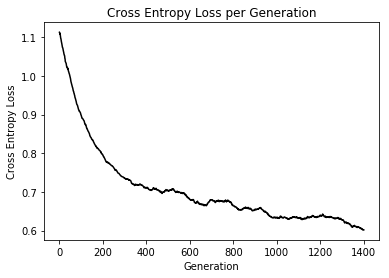

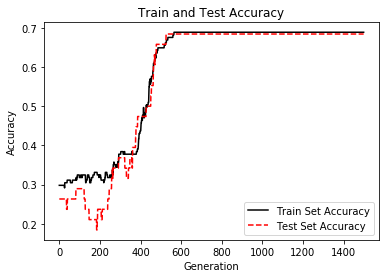

In [12]:
%matplotlib inline

# Smooth the loss
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# Plot loss over time
plt.plot(running_mean(loss_vec,100), 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

# Plot train and test accuracy
plt.plot(train_acc, 'k-', label='Train Set Accuracy')
plt.plot(test_acc, 'r--', label='Test Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()